In [2]:
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

In [3]:
# Konstante
SENSEBOX_ID="6793f4e4c326f20007c34dd2"
API_URL_FORMAT_BOX="https://api.opensensemap.org/boxes/{sensebox_id}?format={response_format}"
API_URL_FORMAT_SENSOR="https://api.opensensemap.org/boxes/{sensebox_id}/data/{sensor_id}?from-date={fromDate}&to-date={toDate}&download=true&format=json"

# Ein dict erzeugen mit {sensor name : sensor id} und ausgeben lassen
def get_sensor_names_ids():
    url = API_URL_FORMAT_BOX.format(sensebox_id=SENSEBOX_ID,response_format="json")
    status_code = requests.get(url).status_code
    assert status_code , f"Failed fetching data from api {status_code}"
    
    sensors = requests.get(url).json().get("sensors")
    sensor_name_id = {}
    for sensor in sensors:
        name = sensor.get('title').replace(" ","").replace(".","_").replace("-","_")
        _id = sensor.get('_id')
        sensor_name_id.update({name : _id})
    return sensor_name_id

### So kann man die namen und ids als eine Liste haben

In [5]:
get_sensor_names_ids().keys(), get_sensor_names_ids().values()

(dict_keys(['Temperatur', 'rel_Luftfeuchte', 'Beleuchtungsstärke', 'UV_Intensität', 'PM1', 'PM2_5', 'PM4', 'PM10']),
 dict_values(['6793f4e4c326f20007c34dd3', '6793f4e4c326f20007c34dd4', '6793f4e4c326f20007c34dd5', '6793f4e4c326f20007c34dd6', '6793f4e4c326f20007c34dd7', '6793f4e4c326f20007c34dd8', '6793f4e4c326f20007c34dd9', '6793f4e4c326f20007c34dda']))

### Dict Ausgabe von der Funktion

In [7]:
get_sensor_names_ids()

{'Temperatur': '6793f4e4c326f20007c34dd3',
 'rel_Luftfeuchte': '6793f4e4c326f20007c34dd4',
 'Beleuchtungsstärke': '6793f4e4c326f20007c34dd5',
 'UV_Intensität': '6793f4e4c326f20007c34dd6',
 'PM1': '6793f4e4c326f20007c34dd7',
 'PM2_5': '6793f4e4c326f20007c34dd8',
 'PM4': '6793f4e4c326f20007c34dd9',
 'PM10': '6793f4e4c326f20007c34dda'}

### So kann man auf die einzelne Namen zugreifen

In [9]:
sensor_id = get_sensor_names_ids()["Temperatur"]
sensor_id

'6793f4e4c326f20007c34dd3'

### create_dataframe function mit inputs sensor_id und from- und toDate die einen default Wert haben

In [11]:
def create_dataframe(days_back=100):
    sensor_ids = get_sensor_names_ids()
    end_date = datetime.utcnow()
    start_date = end_date - timedelta(days=days_back)

    df_all = pd.DataFrame()

    for name, sensor_id in sensor_ids.items():
        url = API_URL_FORMAT_SENSOR.format(
            sensebox_id=SENSEBOX_ID,
            sensor_id=sensor_id,
            fromDate=start_date.isoformat() + "Z",
            toDate=end_date.isoformat() + "Z"
        )
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Fehler beim Abrufen von {name}: {response.status_code}")
            continue

        data = response.json()
        if not data:
            print(f"Keine Daten für {name}")
            continue

        df_sensor = pd.DataFrame(data)
        df_sensor["createdAt"] = pd.to_datetime(df_sensor["createdAt"])
        df_sensor = df_sensor[["createdAt", "value"]].rename(columns={"value": name})
        df_sensor.set_index("createdAt", inplace=True)

        df_all = df_all.join(df_sensor, how="outer")

    return df_all.sort_index()

In [12]:
#data = create_dataframe(sensor_id=get_sensor_names_ids()["Temperatur"])

In [13]:
#data

In [14]:
df = create_dataframe()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2025-05-16 16:01:15.663000+00:00 to 2025-05-24 16:08:29.394000+00:00
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Temperatur          10000 non-null  object
 1   rel_Luftfeuchte     10000 non-null  object
 2   Beleuchtungsstärke  10000 non-null  object
 3   UV_Intensität       10000 non-null  object
 4   PM1                 10000 non-null  object
 5   PM2_5               10000 non-null  object
 6   PM4                 10000 non-null  object
 7   PM10                10000 non-null  object
dtypes: object(8)
memory usage: 703.1+ KB


### Modelltraining für die Vorhersage der Temperatur

In [17]:
target_column = "Temperatur"
X = df.drop(columns=[target_column])
y = df[target_column]

# 2. Fehlende Werte auffüllen (z. B. mit Mittelwert)
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# 3. Split in Training und Test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 4. Modell trainieren
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Vorhersagen
y_pred = model.predict(X_test)

# 6. Bewertung
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAE: 0.39
R²: 0.96


Die Werte sind sehr sehr gut, sieht nach Overfitting aus. Aber sehen wir mal weiter

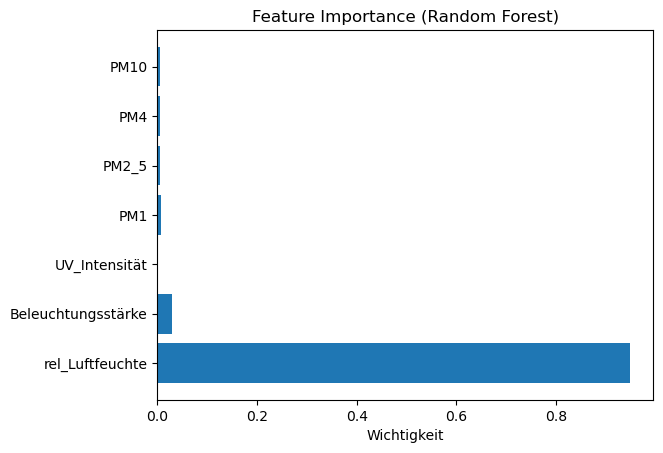

In [29]:
import matplotlib.pyplot as plt

feature_names = X.columns
importances = model.feature_importances_

plt.barh(feature_names, importances)
plt.xlabel("Wichtigkeit")
plt.title("Feature Importance (Random Forest)")
plt.show()